# 📊 Comprehensive Model Comparison: Regression vs Classification

**Purpose**: Benchmark all regression (value prediction) and classification (direction prediction) models on AAPL to compare:
- **Traditional metrics**: R², RMSE, MAE, MAPE for regression
- **Classification metrics**: Accuracy, Balanced Accuracy, F1, ROC-AUC, UP/DOWN recall
- **Directional accuracy**: How often we get the sign of the move correct (for both approaches)

**Output**: 6-9 publication-ready figures saved to `comparison_outputs/`

## 1. Configuration

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)

try:
    from xgboost import XGBRegressor, XGBClassifier
    HAS_XGB = True
except:
    HAS_XGB = False
    print("⚠️ XGBoost not installed")

try:
    import lightgbm as lgb
    HAS_LGB = True
except:
    HAS_LGB = False
    print("⚠️ LightGBM not installed")

try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except:
    HAS_SMOTE = False
    print("⚠️ imbalanced-learn not installed (SMOTE disabled)")

try:
    import ta
    HAS_TA = True
except:
    HAS_TA = False
    print("❌ 'ta' library required. Install: pip install ta")

print("✅ Imports complete")

✅ Imports complete


In [2]:
# Configuration
SYMBOL = "AAPL"
PERIOD = "730d"  # ~2 years
INTERVAL = "1h"   # 1-hour bars
HORIZON = 2       # Predict 2 bars ahead
THRESHOLD = 0.002 # 0.2% movement to count as UP
N_SPLITS = 5      # TimeSeriesSplit folds
OUTDIR = "comparison_outputs"
RANDOM_STATE = 42

os.makedirs(OUTDIR, exist_ok=True)
print(f"📁 Output directory: {OUTDIR}")
print(f"📊 Config: {SYMBOL}, {PERIOD}, {INTERVAL}, horizon={HORIZON}, threshold={THRESHOLD*100:.2f}%")

📁 Output directory: comparison_outputs
📊 Config: AAPL, 730d, 1h, horizon=2, threshold=0.20%


## 2. Data Fetching & Feature Engineering

In [3]:
print(f"🔄 Fetching {SYMBOL} data...")
df = yf.download(SYMBOL, period=PERIOD, interval=INTERVAL, auto_adjust=True, progress=False)

if df.empty:
    raise RuntimeError(f"No data for {SYMBOL}")

df = df.reset_index()
cols = [c[0] if isinstance(c, tuple) else c for c in df.columns]
df.columns = cols

if "Datetime" not in df.columns:
    if "Date" in df.columns:
        df = df.rename(columns={"Date": "Datetime"})
    else:
        df.insert(0, "Datetime", pd.to_datetime(df.index))
        df = df.reset_index(drop=True)

print(f"✅ Fetched {len(df)} rows")
df.head()

🔄 Fetching AAPL data...
✅ Fetched 5081 rows


,Datetime,Close,High,Low,Open,Volume
0,2022-12-13 14:30:00+00:00,148.089996,149.969193,147.940002,149.500000,23245776
1,2022-12-13 15:30:00+00:00,147.559998,148.349594,146.910004,148.080093,11839138
2,2022-12-13 16:30:00+00:00,144.800003,148.108200,144.610001,147.565002,12016715
3,2022-12-13 17:30:00+00:00,145.544998,145.630005,144.240005,144.794998,8694450
4,2022-12-13 18:30:00+00:00,145.100006,145.770004,144.279999,145.539993,8659301


In [4]:
print("🔧 Engineering ~86 technical indicators...")
if not HAS_TA:
    raise RuntimeError("ta library required. Install: pip install ta")

base = df.copy()
base = ta.add_all_ta_features(
    base,
    open="Open", high="High", low="Low", close="Close", volume="Volume",
    fillna=True
)

# Log-transform volume AFTER computing indicators
base["Volume"] = np.log1p(base["Volume"])

print(f"✅ Engineered {len(base.columns)} columns")
print(f"   Sample features: {list(base.columns[:10])}")

🔧 Engineering ~86 technical indicators...
✅ Engineered 92 columns
   Sample features: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi']


## 3. Build Regression & Classification Datasets

In [5]:
print("🎯 Building targets...")

# Regression target: future close
base["Close_future"] = base["Close"].shift(-HORIZON)

# Future return
base["ret_future"] = (base["Close_future"] - base["Close"]) / base["Close"].replace(0, np.nan)

# Classification target: UP=1 if return > threshold, else DOWN=0
base["y_cls"] = (base["ret_future"] > THRESHOLD).astype(int)

# Drop rows with NaNs from shifting
base = base.dropna(subset=["Close_future", "ret_future", "y_cls"])

# Features: all numeric columns except targets and datetime
drop_cols = {"Close_future", "ret_future", "y_cls", "Datetime"}
X = base.select_dtypes(include=[np.number]).drop(
    columns=[c for c in drop_cols if c in base.columns], errors="ignore"
)

y_reg = base["Close_future"].copy()
y_cls = base["y_cls"].copy()
close_now = base["Close"].copy()  # for directional accuracy calc

# Drop any remaining NaNs/infs
mask = np.isfinite(X).all(axis=1)
X = X[mask]
y_reg = y_reg[mask]
y_cls = y_cls[mask]
close_now = close_now[mask]

print(f"✅ Final dataset: {len(X)} samples, {len(X.columns)} features")
print(f"   UP class: {y_cls.sum()} ({y_cls.mean()*100:.1f}%)")
print(f"   DOWN class: {(1-y_cls).sum()} ({(1-y_cls.mean())*100:.1f}%)")

🎯 Building targets...
✅ Final dataset: 5079 samples, 91 features
   UP class: 1892 (37.3%)
   DOWN class: 3187 (62.7%)


## 4. Define Models

In [6]:
# Regression models
regression_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000),
    "RandomForestReg": RandomForestRegressor(
        n_estimators=300, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "GradientBoostingReg": GradientBoostingRegressor(random_state=RANDOM_STATE),
}
if HAS_XGB:
    regression_models["XGBRegressor"] = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
    )

print(f"Regression models: {list(regression_models.keys())}")

Regression models: ['LinearRegression', 'Ridge', 'Lasso', 'RandomForestReg', 'GradientBoostingReg', 'XGBRegressor']


In [7]:
# Classification models
classification_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}
if HAS_XGB:
    classification_models["XGBoost"] = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1
    )
if HAS_LGB:
    classification_models["LightGBM"] = lgb.LGBMClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )

print(f"Classification models: {list(classification_models.keys())}")

Classification models: ['RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']


## 5. Regression Cross-Validation

In [8]:
def directional_accuracy_from_regression(y_pred, close_now_arr, y_future_arr, threshold):
    """Compute directional accuracy from regression predictions."""
    ret_pred = (y_pred - close_now_arr) / close_now_arr
    ret_true = (y_future_arr - close_now_arr) / close_now_arr
    pred_label = (ret_pred > threshold).astype(int)
    true_label = (ret_true > threshold).astype(int)
    return (pred_label == true_label).mean()

print("🚀 Running Regression CV...")
scaler = RobustScaler()
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

reg_results = []
reg_holdout = {}  # store last fold for plotting

for name, model in regression_models.items():
    print(f"  📊 {name}...")
    r2_scores, rmses, maes, mapes, dir_accs = [], [], [], [], []
    y_true_hold, y_pred_hold, close_now_hold = None, None, None
    
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]
        c_train, c_test = close_now.iloc[train_idx], close_now.iloc[test_idx]
        
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        
        r2_scores.append(r2_score(y_test, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        maes.append(mean_absolute_error(y_test, y_pred))
        
        # Safe MAPE
        mape = np.mean(np.abs((y_test - y_pred) / np.clip(np.abs(y_test), 1e-8, None))) * 100.0
        mapes.append(mape)
        
        dir_accs.append(directional_accuracy_from_regression(
            y_pred, c_test.values, y_test.values, THRESHOLD
        ))
        
        # Save last fold
        if fold_idx == N_SPLITS - 1:
            y_true_hold = y_test.values
            y_pred_hold = y_pred
            close_now_hold = c_test.values
    
    reg_results.append({
        "Model": name,
        "R2_mean": np.mean(r2_scores),
        "RMSE_mean": np.mean(rmses),
        "MAE_mean": np.mean(maes),
        "MAPE_mean": np.mean(mapes),
        "Directional_Accuracy_mean": np.mean(dir_accs),
    })
    reg_holdout[name] = {
        "y_true": y_true_hold,
        "y_pred": y_pred_hold,
        "close_now": close_now_hold,
    }

df_reg = pd.DataFrame(reg_results).sort_values("R2_mean", ascending=False)
print("\n✅ Regression CV complete")
df_reg

🚀 Running Regression CV...
  📊 LinearRegression...
  📊 Ridge...
  📊 Lasso...
  📊 RandomForestReg...
  📊 GradientBoostingReg...
  📊 XGBRegressor...

✅ Regression CV complete


,Model,R2_mean,RMSE_mean,MAE_mean,MAPE_mean,Directional_Accuracy_mean
2,Lasso,0.968311,2.022564,1.396582,0.686205,0.569031
1,Ridge,0.967786,2.050657,1.433974,0.704833,0.562411
0,LinearRegression,0.961724,2.135899,1.468028,0.722458,0.543262
3,RandomForestReg,-0.500207,9.606269,8.031230,3.644038,0.585579
5,XGBRegressor,-0.585433,10.055514,8.344273,3.774858,0.588180
4,GradientBoostingReg,-0.608307,10.109764,8.466788,3.825113,0.591017


## 6. Classification Cross-Validation

In [9]:
print("🚀 Running Classification CV...")
scaler = RobustScaler()
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
smote = SMOTE(random_state=RANDOM_STATE) if HAS_SMOTE else None

cls_results = []
cls_holdout = {}  # store last fold for plotting

for name, model in classification_models.items():
    print(f"  📊 {name}...")
    accs, bal_accs, f1s, aucs, up_recalls, dn_recalls = [], [], [], [], [], []
    y_true_hold, y_prob_hold, y_pred_hold = None, None, None
    
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_cls.iloc[train_idx], y_cls.iloc[test_idx]
        
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        # Apply SMOTE if available
        if smote is not None:
            X_train_s, y_train = smote.fit_resample(X_train_s, y_train)
        
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        
        accs.append(accuracy_score(y_test, y_pred))
        bal_accs.append(balanced_accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        
        # ROC-AUC
        try:
            y_prob = model.predict_proba(X_test_s)[:, 1]
            aucs.append(roc_auc_score(y_test, y_prob))
        except:
            try:
                y_scores = model.decision_function(X_test_s)
                y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)
                aucs.append(roc_auc_score(y_test, y_prob))
            except:
                aucs.append(np.nan)
                y_prob = None
        
        # Confusion matrix for recalls
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        up_recalls.append(tp / (tp + fn + 1e-9))
        dn_recalls.append(tn / (tn + fp + 1e-9))
        
        # Save last fold
        if fold_idx == N_SPLITS - 1:
            y_true_hold = y_test.values
            y_pred_hold = y_pred
            y_prob_hold = y_prob
    
    cls_results.append({
        "Model": name,
        "Accuracy": np.mean(accs),
        "Balanced_Accuracy": np.mean(bal_accs),
        "F1": np.mean(f1s),
        "ROC_AUC": np.nanmean(aucs),
        "UP_Recall": np.mean(up_recalls),
        "DOWN_Recall": np.mean(dn_recalls),
    })
    cls_holdout[name] = {
        "y_true": y_true_hold,
        "y_pred": y_pred_hold,
        "y_prob": y_prob_hold,
    }

df_cls = pd.DataFrame(cls_results).sort_values("Accuracy", ascending=False)
print("\n✅ Classification CV complete")
df_cls

🚀 Running Classification CV...
  📊 RandomForest...
  📊 GradientBoosting...
  📊 XGBoost...
  📊 LightGBM...
[LightGBM] [Info] Number of positive: 505, number of negative: 505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21121
[LightGBM] [Info] Number of data points in the train set: 1010, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

,Model,Accuracy,Balanced_Accuracy,F1,ROC_AUC,UP_Recall,DOWN_Recall
2,XGBoost,0.600946,0.519032,0.249406,0.531293,0.205720,0.832344
3,LightGBM,0.599527,0.505668,0.201007,0.528285,0.151393,0.859942
1,GradientBoosting,0.583452,0.504766,0.242059,0.515032,0.205768,0.803764
0,RandomForest,0.569740,0.503852,0.275563,0.532774,0.248977,0.758727


## 7. Save CSV Results

In [10]:
df_reg.to_csv(os.path.join(OUTDIR, "regression_metrics.csv"), index=False)
df_cls.to_csv(os.path.join(OUTDIR, "classification_metrics.csv"), index=False)

# Combined directional accuracy table
df_reg2 = df_reg[["Model", "Directional_Accuracy_mean"]].rename(
    columns={"Directional_Accuracy_mean": "Directional_Accuracy"}
)
df_cls2 = df_cls[["Model", "Accuracy"]].rename(columns={"Accuracy": "Directional_Accuracy"})
df_reg2["Type"] = "Regression"
df_cls2["Type"] = "Classification"
df_all = pd.concat([df_reg2, df_cls2], ignore_index=True)
df_all.to_csv(os.path.join(OUTDIR, "combined_directional_accuracy.csv"), index=False)

print(f"✅ CSVs saved to {OUTDIR}/")

✅ CSVs saved to comparison_outputs/


## 8. Visualizations

### 8.1 Regression: R² Ranking

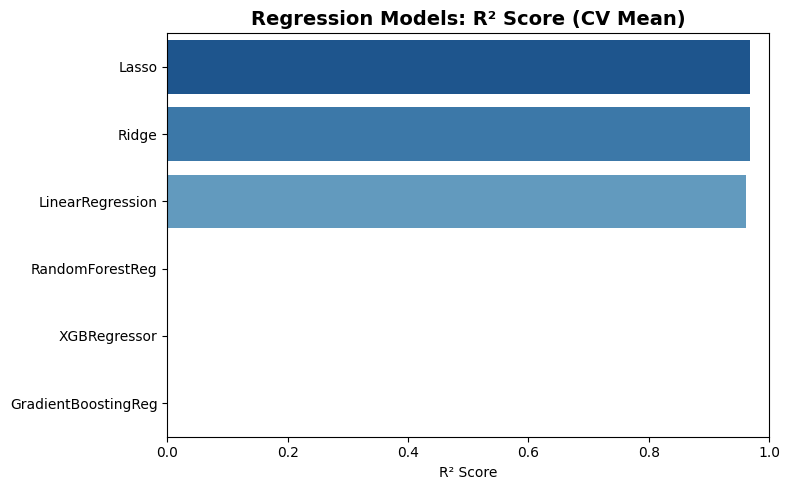

✅ Saved: regression_r2_ranking.png


In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(x="R2_mean", y="Model", data=df_reg, palette="Blues_r")
plt.title("Regression Models: R² Score (CV Mean)", fontsize=14, fontweight='bold')
plt.xlabel("R² Score")
plt.ylabel("")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "regression_r2_ranking.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: regression_r2_ranking.png")

### 8.2 Regression: Predicted vs Actual (Best Model)

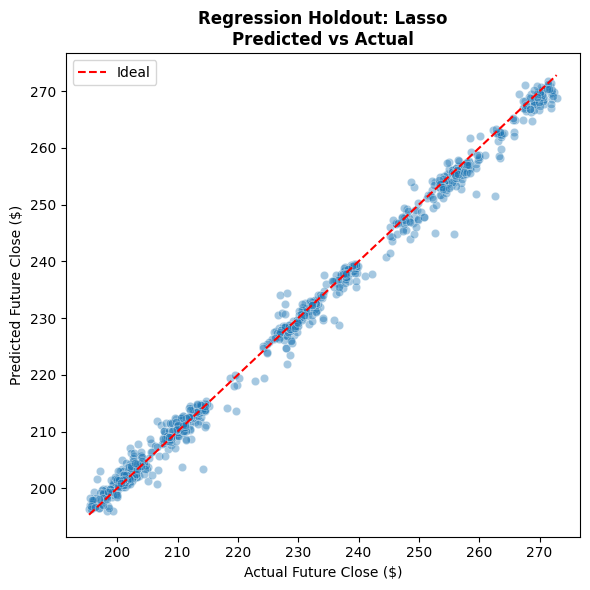

✅ Saved: regression_pred_vs_actual.png


In [12]:
top_reg_model = df_reg.iloc[0]["Model"]
data = reg_holdout[top_reg_model]
y_true = data["y_true"]
y_pred = data["y_pred"]

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("Actual Future Close ($)")
plt.ylabel("Predicted Future Close ($)")
plt.title(f"Regression Holdout: {top_reg_model}\nPredicted vs Actual", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "regression_pred_vs_actual.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: regression_pred_vs_actual.png")

### 8.3 Classification: Metrics Bar Chart

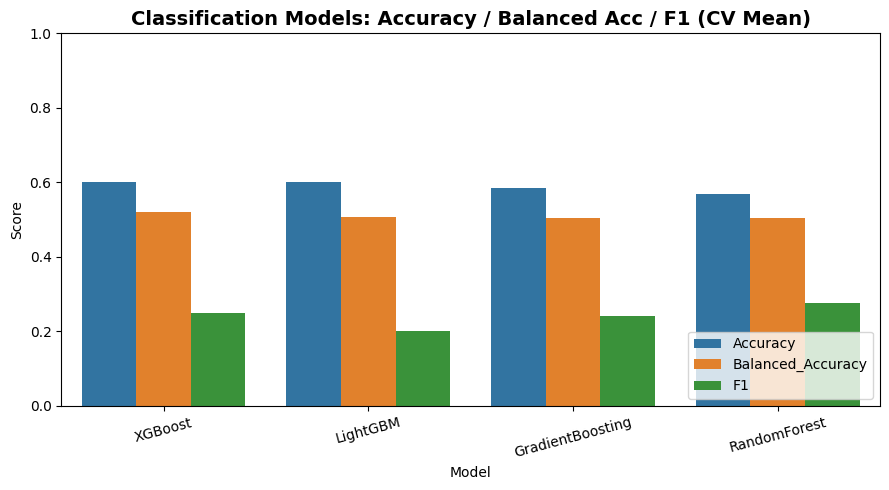

✅ Saved: classification_metrics_bar.png


In [13]:
plt.figure(figsize=(9, 5))
dfm = df_cls.melt(
    id_vars=["Model"],
    value_vars=["Accuracy", "Balanced_Accuracy", "F1"],
    var_name="Metric",
    value_name="Score"
)
sns.barplot(x="Model", y="Score", hue="Metric", data=dfm)
plt.title("Classification Models: Accuracy / Balanced Acc / F1 (CV Mean)", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "classification_metrics_bar.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: classification_metrics_bar.png")

### 8.4 Classification: Confusion Matrix (Best Model)

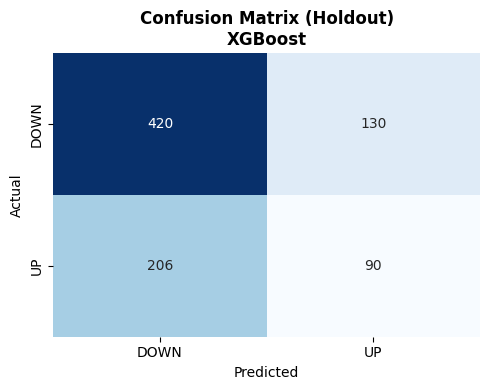

✅ Saved: classification_confusion_matrix_best.png


In [14]:
top_cls_model = df_cls.iloc[0]["Model"]
data = cls_holdout[top_cls_model]
y_true = data["y_true"]
y_pred = data["y_pred"]
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["DOWN","UP"], yticklabels=["DOWN","UP"])
plt.title(f"Confusion Matrix (Holdout)\n{top_cls_model}", fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "classification_confusion_matrix_best.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: classification_confusion_matrix_best.png")

### 8.5 Classification: ROC Curves

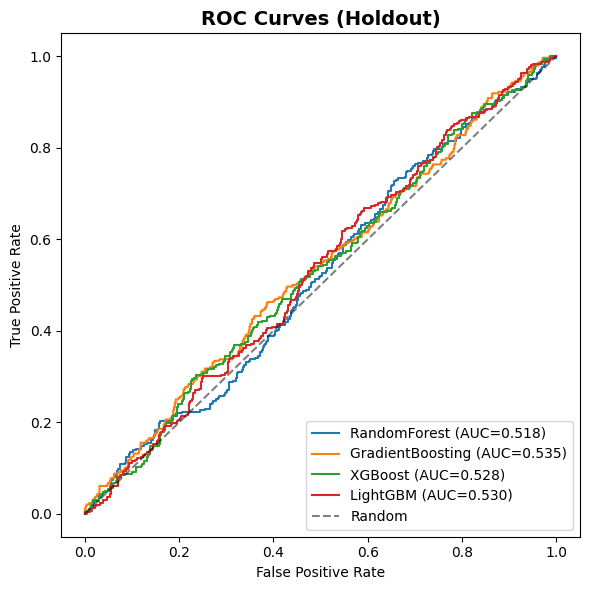

✅ Saved: classification_roc_curves.png


In [15]:
plt.figure(figsize=(6, 6))
for name in cls_holdout.keys():
    data = cls_holdout[name]
    if data.get("y_prob") is None:
        continue
    y_true = data["y_true"]
    y_prob = data["y_prob"]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

plt.plot([0,1], [0,1], 'k--', alpha=0.5, label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Holdout)", fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "classification_roc_curves.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: classification_roc_curves.png")

### 8.6 Directional Accuracy: Regression vs Classification

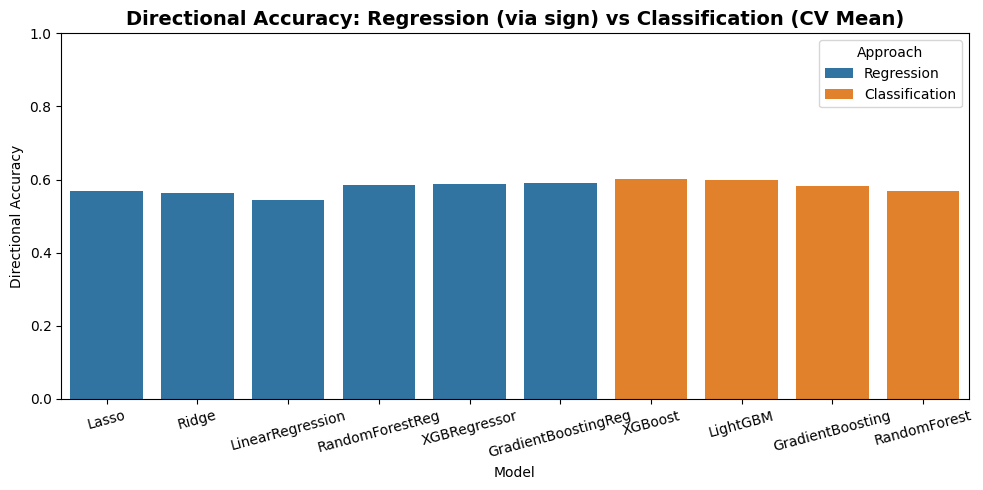

✅ Saved: directional_accuracy_comparison.png


In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Directional_Accuracy", hue="Type", data=df_all)
plt.ylim(0.0, 1.0)
plt.title("Directional Accuracy: Regression (via sign) vs Classification (CV Mean)", fontsize=14, fontweight='bold')
plt.ylabel("Directional Accuracy")
plt.xticks(rotation=15)
plt.legend(title="Approach")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "directional_accuracy_comparison.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: directional_accuracy_comparison.png")

## 9. Summary

In [17]:
print("="*60)
print("📊 COMPREHENSIVE MODEL COMPARISON COMPLETE")
print("="*60)
print(f"\n📁 All outputs saved to: {OUTDIR}/")
print("\n📈 Regression Metrics:")
print(df_reg.to_string(index=False))
print("\n🎯 Classification Metrics:")
print(df_cls.to_string(index=False))
print("\n🔍 Key Insights:")
print(f"  • Best Regression (R²): {df_reg.iloc[0]['Model']} ({df_reg.iloc[0]['R2_mean']:.4f})")
print(f"  • Best Classification (Acc): {df_cls.iloc[0]['Model']} ({df_cls.iloc[0]['Accuracy']:.4f})")
print(f"  • Classification balanced accuracy shows class-aware performance")
print(f"  • Directional accuracy directly measures trading decision alignment")
print("\n✅ Use the generated figures in your LaTeX report!")

📊 COMPREHENSIVE MODEL COMPARISON COMPLETE

📁 All outputs saved to: comparison_outputs/

📈 Regression Metrics:
              Model   R2_mean  RMSE_mean  MAE_mean  MAPE_mean  Directional_Accuracy_mean
              Lasso  0.968311   2.022564  1.396582   0.686205                   0.569031
              Ridge  0.967786   2.050657  1.433974   0.704833                   0.562411
   LinearRegression  0.961724   2.135899  1.468028   0.722458                   0.543262
    RandomForestReg -0.500207   9.606269  8.031230   3.644038                   0.585579
       XGBRegressor -0.585433  10.055514  8.344273   3.774858                   0.588180
GradientBoostingReg -0.608307  10.109764  8.466788   3.825113                   0.591017

🎯 Classification Metrics:
           Model  Accuracy  Balanced_Accuracy       F1  ROC_AUC  UP_Recall  DOWN_Recall
         XGBoost  0.600946           0.519032 0.249406 0.531293   0.205720     0.832344
        LightGBM  0.599527           0.505668 0.201007 0.528285 

---

## 📄 REPORT-SPECIFIC FIGURES

Generate publication-ready figures for LaTeX report (Part 2: Classification Model)

In [ ]:
# Create report_figures directory
os.makedirs('report_figures', exist_ok=True)
print("📁 Created report_figures/ directory for LaTeX report images")

### Figure 1: Classification Metrics Bar Chart (XGBoost focus)

In [ ]:
# Classification metrics comparison (for LaTeX Figure)
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['Accuracy', 'Balanced_Accuracy', 'F1']
x = np.arange(len(df_cls))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, df_cls[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Classification Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(df_cls['Model'], rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('report_figures/classification_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: report_figures/classification_metrics_comparison.png")

### Figure 2: XGBoost Confusion Matrix

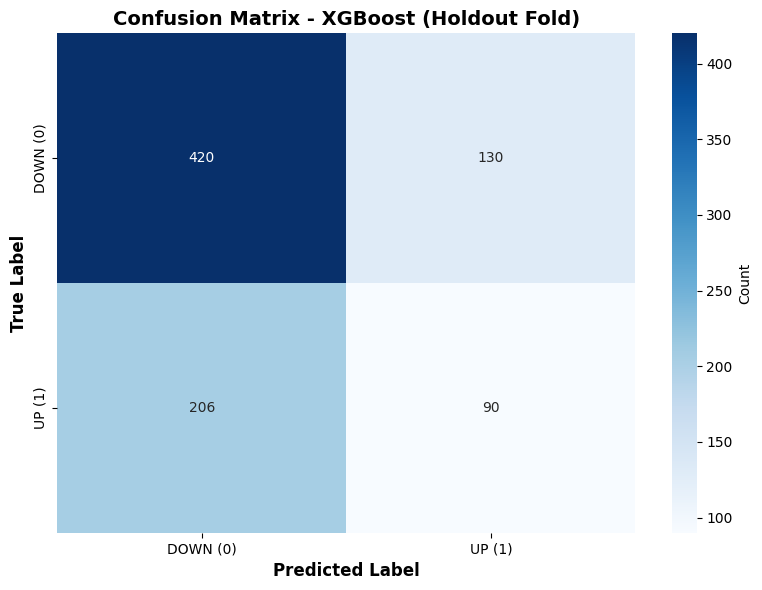

✅ Saved: report_figures/xgb_confusion_matrix.png


In [18]:
# XGBoost Confusion Matrix (for LaTeX)
xgb_model_name = 'XGBoost' if HAS_XGB else df_cls.iloc[0]['Model']
xgb_data = cls_holdout[xgb_model_name]
y_true_xgb = xgb_data['y_true']
y_pred_xgb = xgb_data['y_pred']

cm_xgb = confusion_matrix(y_true_xgb, y_pred_xgb, labels=[0, 1])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['DOWN (0)', 'UP (1)'], 
            yticklabels=['DOWN (0)', 'UP (1)'],
            cbar_kws={'label': 'Count'})
ax.set_title(f'Confusion Matrix - {xgb_model_name} (Holdout Fold)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('report_figures/xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: report_figures/xgb_confusion_matrix.png")

### Figure 3: XGBoost ROC Curve

In [ ]:
# XGBoost ROC Curve (for LaTeX)
xgb_model_name = 'XGBoost' if HAS_XGB else df_cls.iloc[0]['Model']
xgb_data = cls_holdout[xgb_model_name]
y_true_xgb = xgb_data['y_true']
y_prob_xgb = xgb_data['y_prob']

fpr_xgb, tpr_xgb, _ = roc_curve(y_true_xgb, y_prob_xgb)
auc_xgb = roc_auc_score(y_true_xgb, y_prob_xgb)

fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(fpr_xgb, tpr_xgb, color='#2E86AB', linewidth=2.5, label=f'{xgb_model_name} (AUC = {auc_xgb:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.6, label='Random Classifier (AUC = 0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title(f'ROC Curve - {xgb_model_name} (Holdout Fold)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('report_figures/xgb_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: report_figures/xgb_roc_curve.png")

### Figure 4: XGBoost Feature Importance (Top 20)

In [ ]:
# XGBoost Feature Importance (for LaTeX)
xgb_model_name = 'XGBoost' if HAS_XGB else df_cls.iloc[0]['Model']

# Train a fresh XGBoost model on full data to get feature importances
if xgb_model_name in classification_models:
    # Get the model definition
    fresh_model = classification_models[xgb_model_name]
    
    # Train on all data (scaled)
    scaler_temp = RobustScaler()
    X_scaled = scaler_temp.fit_transform(X)
    fresh_model.fit(X_scaled, y_cls)
    
    # Get feature importances
    feature_importance = fresh_model.feature_importances_
    feature_names = X.columns.tolist()
    
    # Create DataFrame and sort
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Top 20 features
    top_20 = importance_df.head(20)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_20)), top_20['Importance'].values, color='#A23B72', alpha=0.8)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['Feature'].values, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 20 Feature Importances - {xgb_model_name}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('report_figures/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: report_figures/xgb_feature_importance.png")
else:
    print(f"❌ Model {xgb_model_name} not found in classification_models")

NameError: name 'cls_models' is not defined

### Figure 5: Directional Accuracy Comparison (Regression vs Classification)

In [ ]:
# Directional Accuracy Comparison: Regression vs Classification (for LaTeX)

# Regression directional accuracy (from reg_fold_performance)
reg_dir_acc = reg_fold_performance['Directional_Accuracy'].values
reg_models = reg_fold_performance['Model'].values

# Classification accuracy (using 'Accuracy' from df_cls as directional accuracy)
cls_dir_acc = df_cls['Accuracy'].values
cls_models_list = df_cls['Model'].values

# Combine both
all_models = list(reg_models) + list(cls_models_list)
all_dir_acc = list(reg_dir_acc) + list(cls_dir_acc)
model_type = ['Regression']*len(reg_models) + ['Classification']*len(cls_models_list)

comparison_df = pd.DataFrame({
    'Model': all_models,
    'Directional_Accuracy': all_dir_acc,
    'Type': model_type
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
colors = ['#06A77D' if t == 'Regression' else '#D64045' for t in comparison_df['Type']]

bars = ax.bar(x, comparison_df['Directional_Accuracy'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Directional Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Directional Accuracy: Regression vs Classification Models', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, comparison_df['Directional_Accuracy'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#06A77D', edgecolor='black', label='Regression'),
    Patch(facecolor='#D64045', edgecolor='black', label='Classification')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('report_figures/directional_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: report_figures/directional_accuracy_comparison.png")